 # DQN Training in Maze Environment (Hyperparameterized)

In [1]:
import maze_library
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import itertools
from collections import deque


2025-04-17 08:23:03.984926: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-17 08:23:04.176025: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-17 08:23:04.338044: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744874584.478209    2622 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744874584.515119    2622 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-17 08:23:04.902805: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

 ## Hyperparameters

In [ ]:
hyperparams = {
    "learning_rate": [5e-5, 1e-5],
    "gamma": [0.96],
    "epsilon_decay_episodes": [0.9],
    "batch_size": [128],
    "replay_buffer_size": [10000],
    "episodes": [3000, 2000],
    "hidden_layers": [
        [64, 64, 64], 
        [128, 128], 
        [64, 128, 128], 
    ],
    "activation": ["elu"]
}

def generate_param_combinations(grid):
    keys = list(grid.keys())
    values = list(grid.values())
    for combination in itertools.product(*values):
        yield dict(zip(keys, combination))

shared_params = {
    "epsilon_start": 1.0,
    "epsilon_min": 0.01,
    "replay_buffer_size": 8000,
    "steps_per_episode": 3000,
    "target_update_freq": 500,
    "random_seed": 42,
    "maze_width": 10,
    "maze_height": 10,
    "maze_imperfections": 5,
    "input_dim": 19,
    "n_outputs": 4,
    "log_every": 1000,
    "q_log_every": 500,
    "plot_every": 100,
    "train_after": 1000
}


# Constants

In [3]:
random_seed = 42
maze_width = 16
maze_height = 16
input_shape = [19]
n_outputs = 4


 ## Maze Setup

In [4]:
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

env = maze_library.init_environment_python(maze_width, maze_height, 5)
maze_library.create_kruzkals_maze(env)
maze_library.make_maze_imperfect(env)


In [5]:
def map_int_to_direction(input):
    return [
        maze_library.Direction.North,
        maze_library.Direction.East,
        maze_library.Direction.South,
        maze_library.Direction.West
    ][input]

def action_result_to_tuple(action_result):
    return (
        action_result.observation,
        action_result.reward,
        action_result.is_done,
        action_result.is_truncated,
        action_result.info
    )

def action_result_to_input_vector(state, info):
    ap = state.available_paths
    vp = state.visited_paths
    return np.array([
        ap.get(maze_library.Direction.North, 0),
        vp.get(maze_library.Direction.North, False),
        ap.get(maze_library.Direction.East, 0),
        vp.get(maze_library.Direction.East, False),
        ap.get(maze_library.Direction.South, 0),
        vp.get(maze_library.Direction.South, False),
        ap.get(maze_library.Direction.West, 0),
        vp.get(maze_library.Direction.West, False),
        info.previous_direction,
        state.current_location[0]/maze_width,
        state.current_location[1]/maze_width,
        state.end_node[0]/maze_width,
        state.end_node[1]/maze_width,
        info.previous_node[0]/maze_width,
        info.previous_node[1]/maze_width,
        info.manhattan_distance/maze_width,
        info.goal_dx,
        info.goal_dy,
        info.visited_amount
    ])


 ## Model Definition

In [6]:

def create_model(hyperprm):
    model = tf.keras.Sequential()
    model.add(tf.keras.Input(shape=input_shape))
    for units in hyperprm["hidden_layers"]:
        model.add(tf.keras.layers.Dense(units, activation=hyperprm["activation"]))
    model.add(tf.keras.layers.Dense(n_outputs))

    optimizer = tf.keras.optimizers.Nadam(learning_rate=hyperprm["learning_rate"])
    loss_fn = tf.keras.losses.Huber(delta=1.0)
    return model, optimizer, loss_fn


 ## Policy and Replay Buffer

In [7]:

def epsilon_greedy_policy(state, epsilon, model):
    if np.random.rand() < epsilon:
        return np.random.choice(n_outputs)
    Q_values = model.predict(state[np.newaxis], verbose=0)[0]
    return np.argmax(Q_values)

def sample_experiences(batch_size, replay_buffer):
    indices = np.random.choice(len(replay_buffer), min(len(replay_buffer), batch_size), replace=False)
    batch = [replay_buffer[i] for i in indices]
    
    return [
        np.array([experience[field_index] for experience in batch], dtype=np.float32)
        for field_index in range(6)
    ]


In [8]:


def play_one_step(env, state, info, epsilon,model, replay_buffer, reward_log):
    flat_state = action_result_to_input_vector(state, info)
    action = epsilon_greedy_policy(flat_state, epsilon, model)
    action_obj = maze_library.create_action(map_int_to_direction(action), 0)
    next_state, reward, done, truncated, new_info = action_result_to_tuple(env.take_action(action_obj))
    flat_next_state = action_result_to_input_vector(next_state, new_info)
    reward_log.append(reward)
    replay_buffer.append((flat_state, action, reward, flat_next_state, done, truncated))
    return next_state, reward, done, truncated, new_info


In [9]:
def training_step(model, optimizer, loss_fn, hyperprm, replay_buffer, q_value_log):
    states, actions, rewards, next_states, dones, truncateds = sample_experiences(hyperprm["batch_size"], replay_buffer)
    next_Q_values = model.predict(next_states, verbose=0)
    max_next_Q = np.max(next_Q_values, axis=1)
    not_done = 1.0 - dones
    targets = rewards + not_done * hyperprm["gamma"] * max_next_Q
    targets = targets.reshape(-1, 1)

    mask = tf.one_hot(actions, n_outputs)
    with tf.GradientTape() as tape:
        all_Q = model(states)
        Q_values = tf.reduce_sum(all_Q * mask, axis=1, keepdims=True)
        q_value_log.extend(Q_values.numpy().flatten())
        loss = tf.reduce_mean(loss_fn(targets, Q_values))

    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))


In [10]:
def plot_q_values(q_value_log):
    plt.figure(figsize=(10, 5))
    plt.plot(q_value_log)
    plt.title("Q-Values Over Time")
    plt.xlabel("Training Steps")
    plt.ylabel("Q-Value")
    plt.grid(True)
    plt.show()


 ## Training Loop

In [11]:
def run_single_experiment(hyperprm, run_id):
    all_episode_rewards  = []
    reward_log = []
    q_value_log = []
    best_weights = None
    highest_reward = -float("inf")
    model, optimizer, loss_fn = create_model(hyperprm)
    replay_buffer = deque(maxlen=hyperprm["replay_buffer_size"])
    print(f"Run {run_id}, Episodes: {hyperprm['episodes']}")

    for episode in range(hyperprm["episodes"]):
        result = env.reset()
        obs, reward, done, truncated, info = action_result_to_tuple(result)
        cumulative_reward = 0

        for step in range(hyperprm["steps_per_episode"]):
            eps_decay = episode / (hyperprm["episodes"] * hyperprm["epsilon_decay_episodes"])
            epsilon = max(hyperprm["epsilon_start"] - eps_decay, hyperprm["epsilon_min"])
            obs, reward, done, truncated, info = play_one_step(env, obs, info, epsilon,model, replay_buffer, reward_log)
            cumulative_reward += reward
            if done or truncated:
                break

        if episode > (hyperprm["episodes"] * 0.33):
            training_step(model, optimizer, loss_fn, hyperprm, replay_buffer, q_value_log)
        
        if cumulative_reward > highest_reward:
            highest_reward = cumulative_reward
            best_weights = model.get_weights()

        if episode % hyperprm["log_every"] == 0 and episode != 0:
            print(f"Run {run_id}, Reward: {np.average(all_episode_rewards[-100:])}")

        # if episode % hyperprm["q_log_every"] == 0 and episode > 0:

        all_episode_rewards.append(cumulative_reward)
        
    plot_q_values(q_value_log)

    model.set_weights(best_weights)
    return {
        "params": hyperprm,
        "rewards": all_episode_rewards,
        "q_values": q_value_log,
        "final_model": model,
    }


Totals combinations = 24


W0000 00:00:1744874587.977534    2622 gpu_device.cc:2344] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Run 0, Episodes: 3000
Run 0, Reward: -24.58750000178814
Run 0, Reward: -14.305999984145165


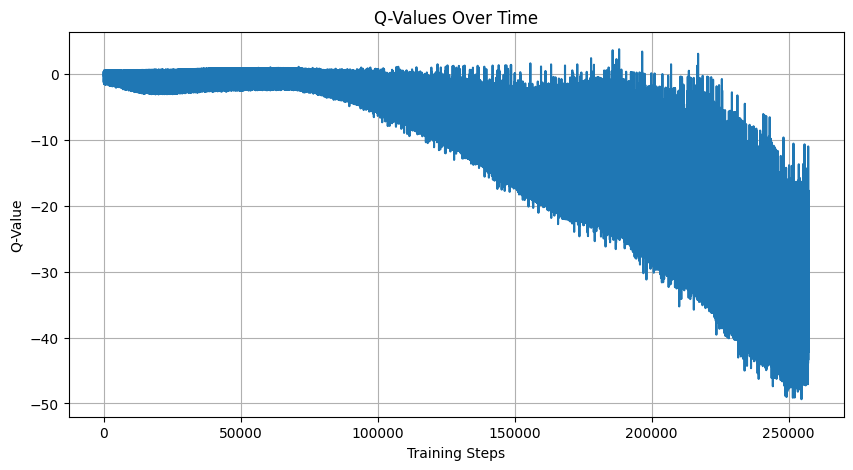

Run 1, Episodes: 3000
Run 1, Reward: -24.29400001168251
Run 1, Reward: -14.71699998319149


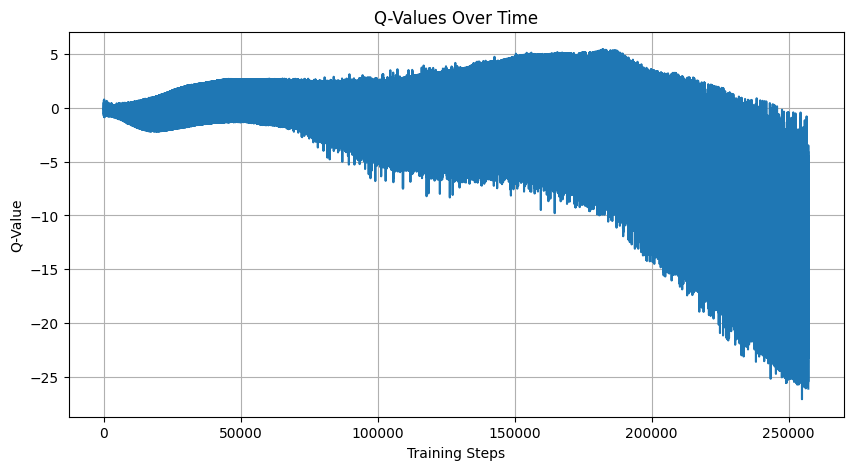

Run 2, Episodes: 3000
Run 2, Reward: -27.022999972701072
Run 2, Reward: -16.01299995303154


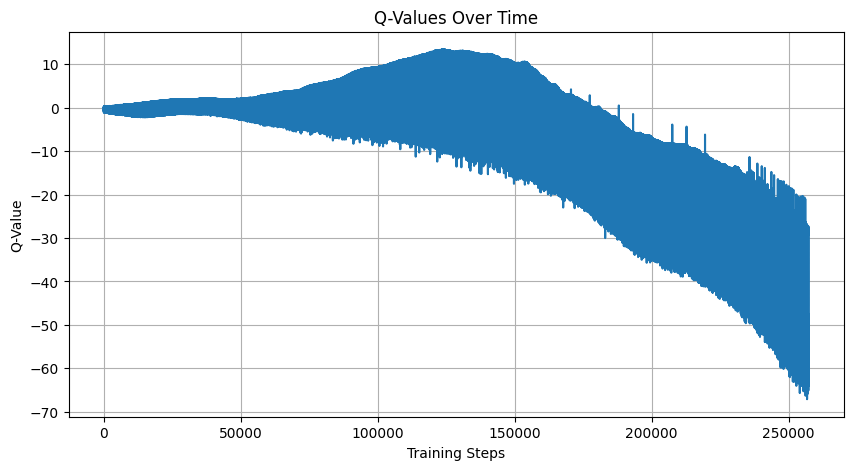

Run 3, Episodes: 2000
Run 3, Reward: -21.523499936461448


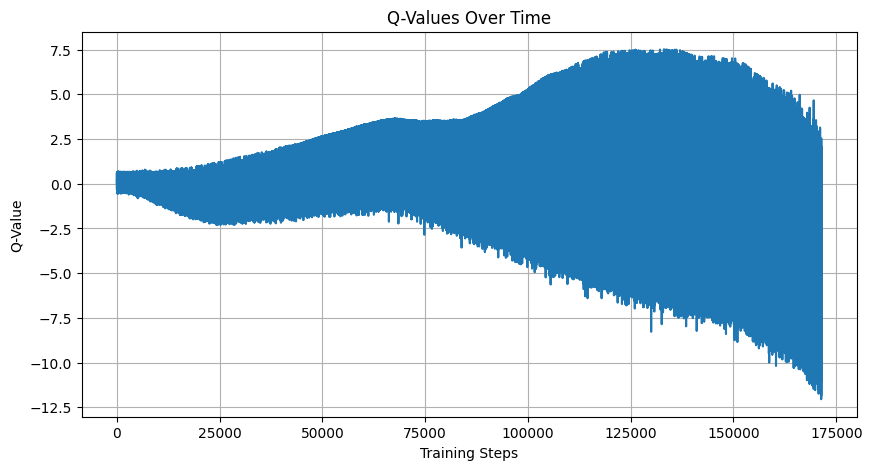

Run 4, Episodes: 2000
Run 4, Reward: -22.339999946057798


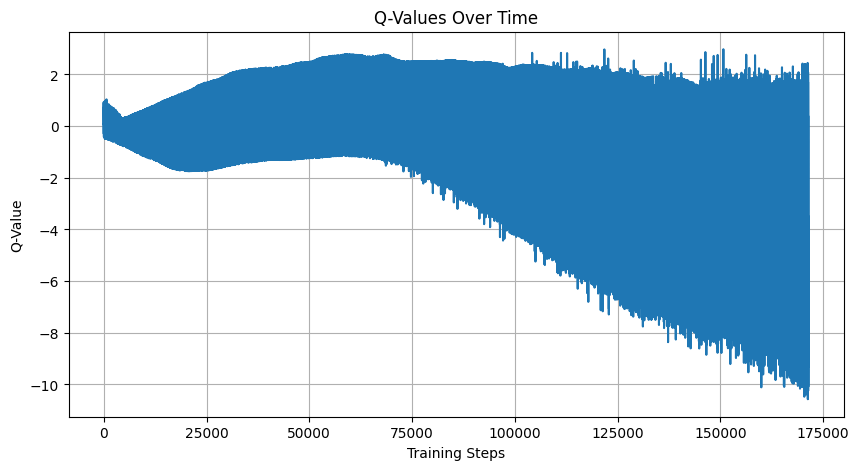

Run 5, Episodes: 2000
Run 5, Reward: -20.553999949097634


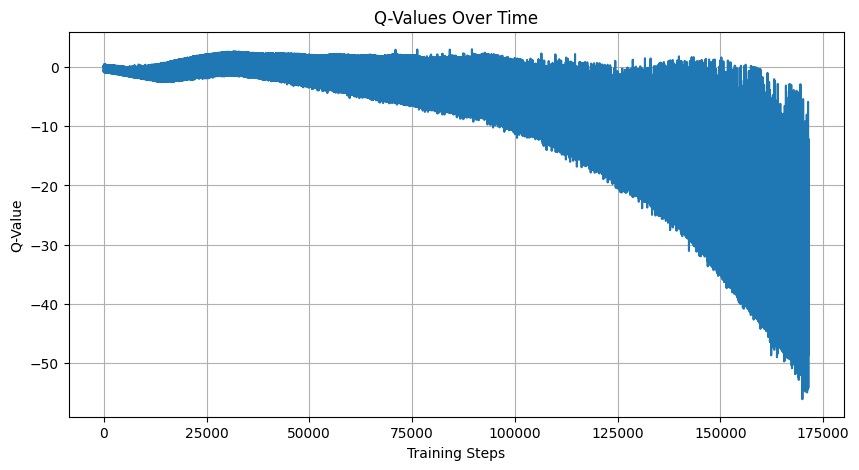

Run 6, Episodes: 3000
Run 6, Reward: -24.312500037252903
Run 6, Reward: -21.03149992763996


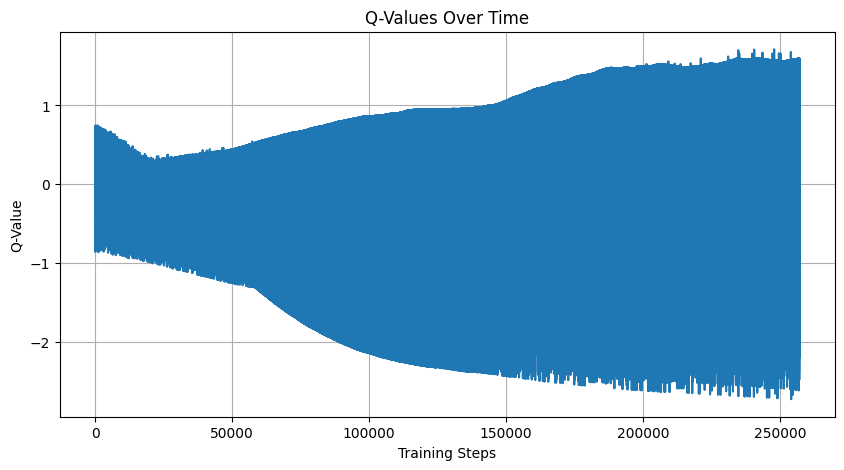

Run 7, Episodes: 3000
Run 7, Reward: -19.832499990165232
Run 7, Reward: -22.27549989670515


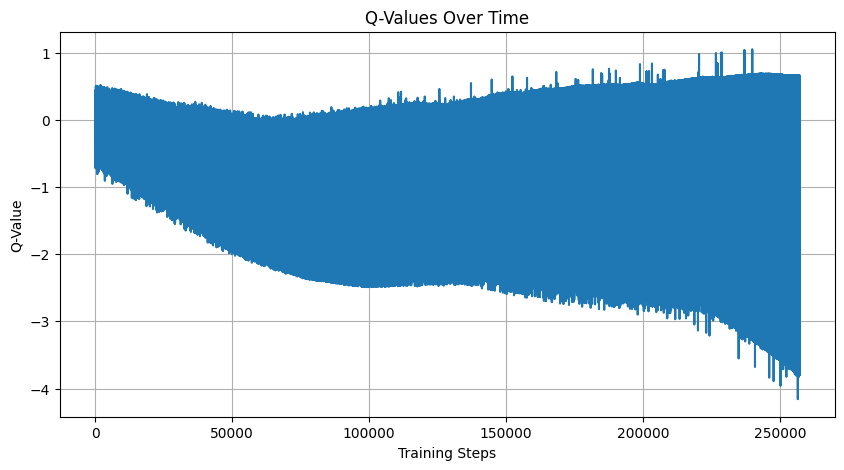

Run 8, Episodes: 3000
Run 8, Reward: -22.288999979496
Run 8, Reward: -14.291000018715858


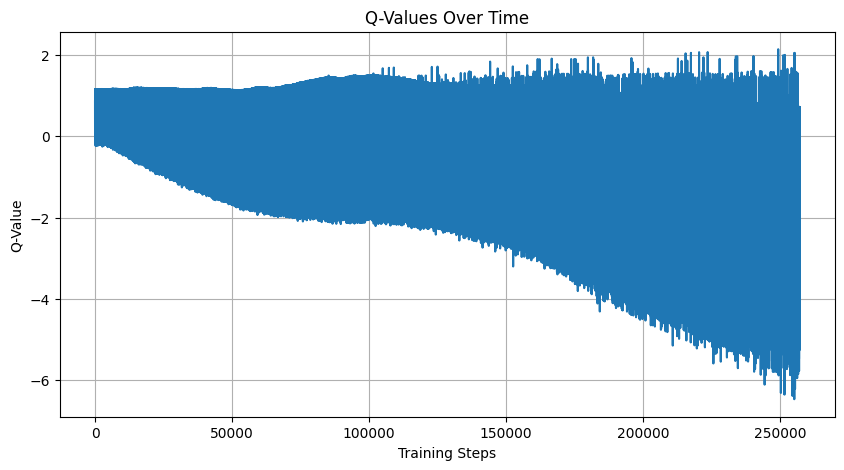

Run 9, Episodes: 2000
Run 9, Reward: -24.398999998271464


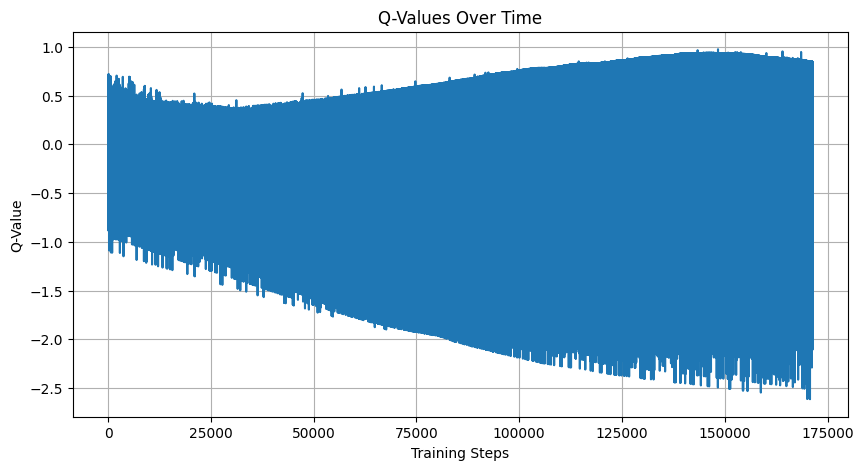

Run 10, Episodes: 2000
Run 10, Reward: -23.272999938726425


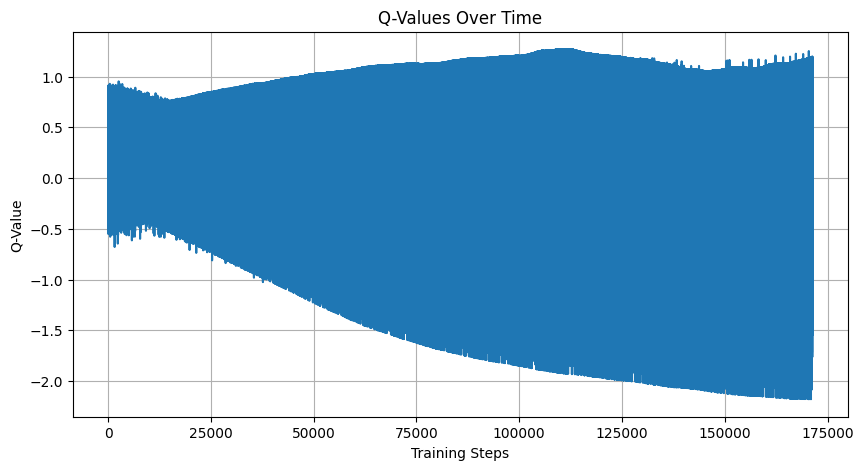

Run 11, Episodes: 2000
Run 11, Reward: -21.61399994522333


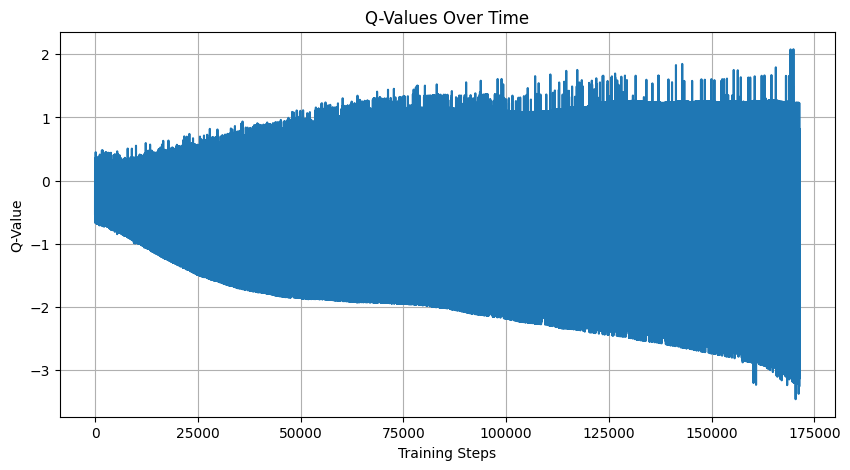

Run 12, Episodes: 3000
Run 12, Reward: -25.04250003427267
Run 12, Reward: -25.887499986290933


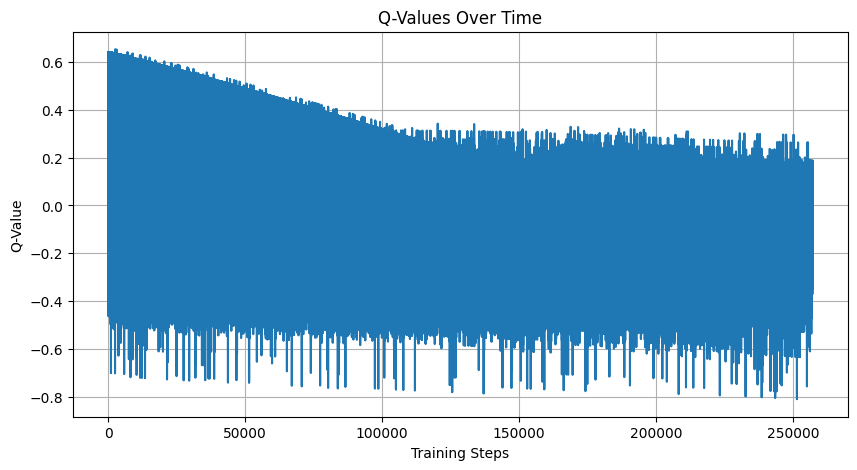

Run 13, Episodes: 3000
Run 13, Reward: -22.766500034630297
Run 13, Reward: -21.45400005489588


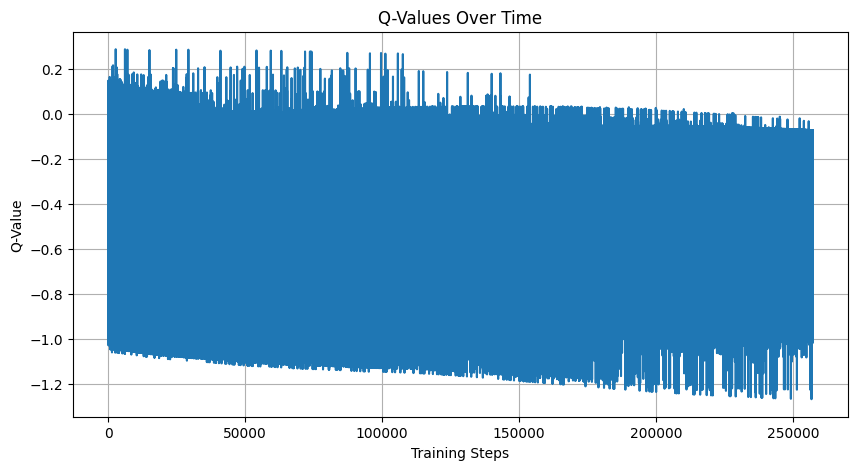

Run 14, Episodes: 3000
Run 14, Reward: -22.923500014841558
Run 14, Reward: -24.283499970138074


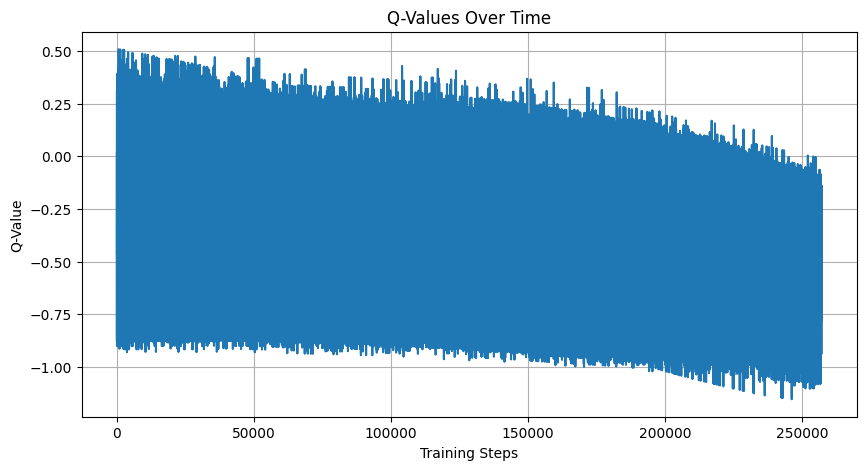

Run 15, Episodes: 2000
Run 15, Reward: -23.97549999088049


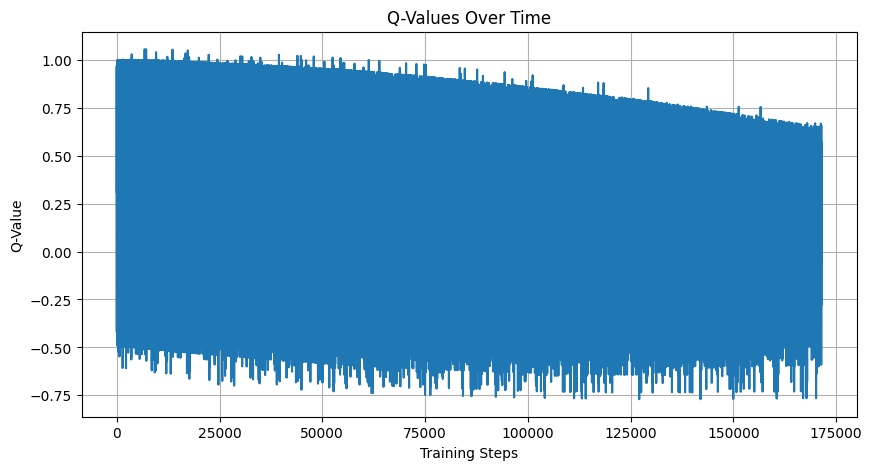

Run 16, Episodes: 2000
Run 16, Reward: -24.993500037789346


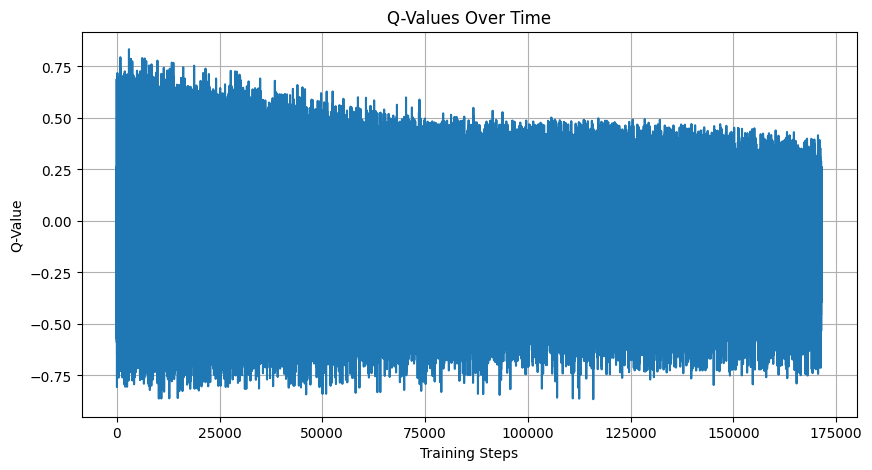

Run 17, Episodes: 2000
Run 17, Reward: -21.549499948620795


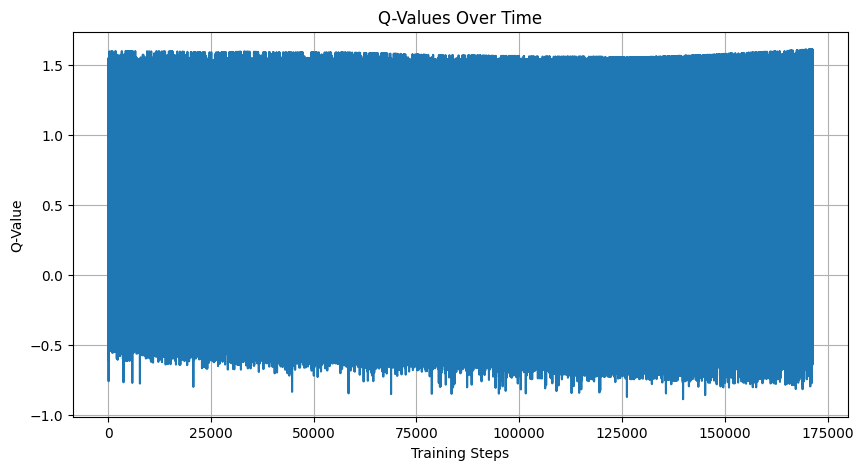

Run 18, Episodes: 3000
Run 18, Reward: -22.68349995225668
Run 18, Reward: -14.789499980807305


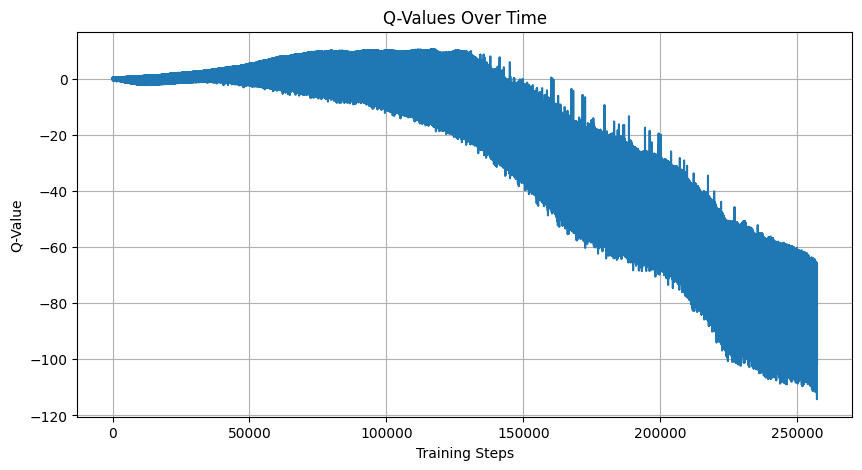

Run 19, Episodes: 3000
Run 19, Reward: -23.457000017166138
Run 19, Reward: -14.575499960780144


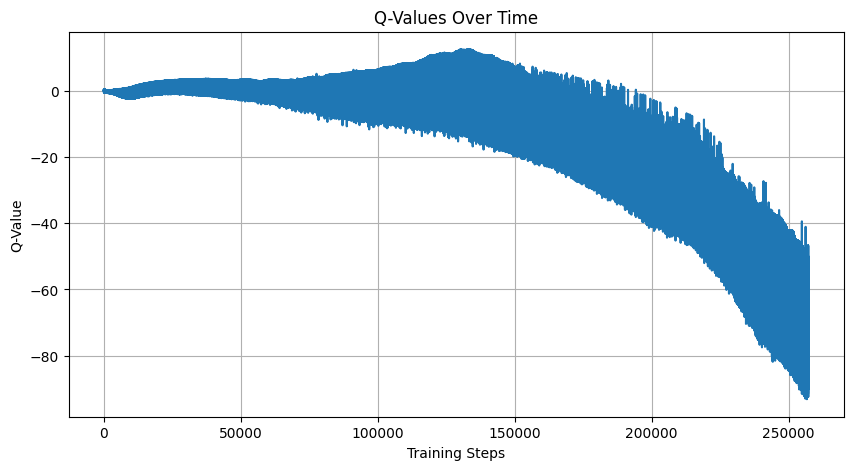

Run 20, Episodes: 3000
Run 20, Reward: -22.810500006973744
Run 20, Reward: -14.370999946594239


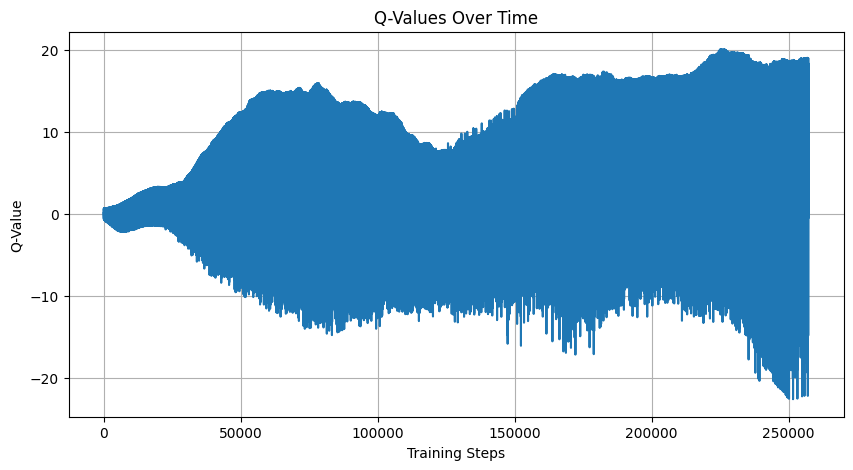

Run 21, Episodes: 2000
Run 21, Reward: -23.39599992901087


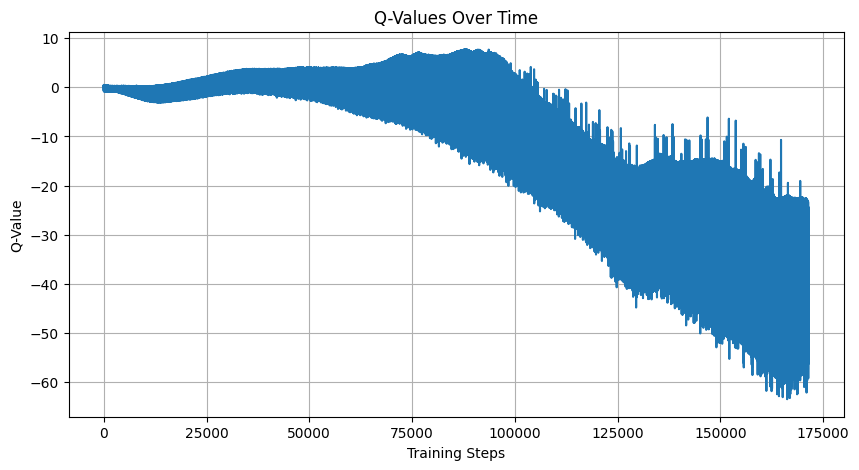

Run 22, Episodes: 2000
Run 22, Reward: -20.993499959409238


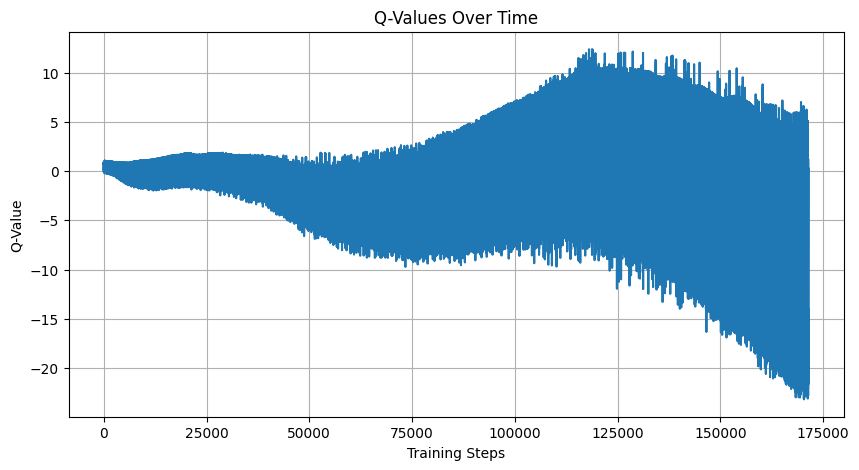

Run 23, Episodes: 2000
Run 23, Reward: -17.005499950349332


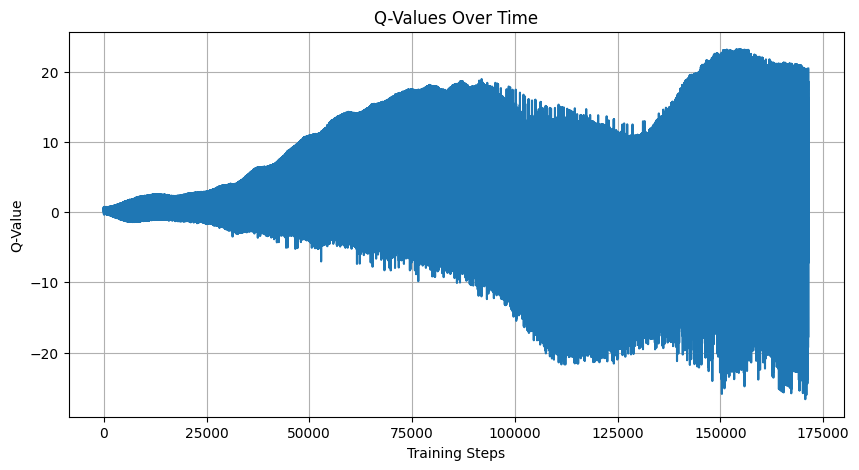

In [12]:
results = []
combo_params = list(generate_param_combinations(hyperparams))
print(f"Totals combinations = {len(combo_params)}")
for i, combo in enumerate(combo_params):
    merged_params = {**shared_params, **combo}
    results.append(run_single_experiment(merged_params, run_id=i))
    

 ## Evaluation

In [13]:
def get_changed_hyperparams(defaults, current):
    return {
        k: v for k, v in current.items()
        if k not in defaults or defaults[k] != v
    }

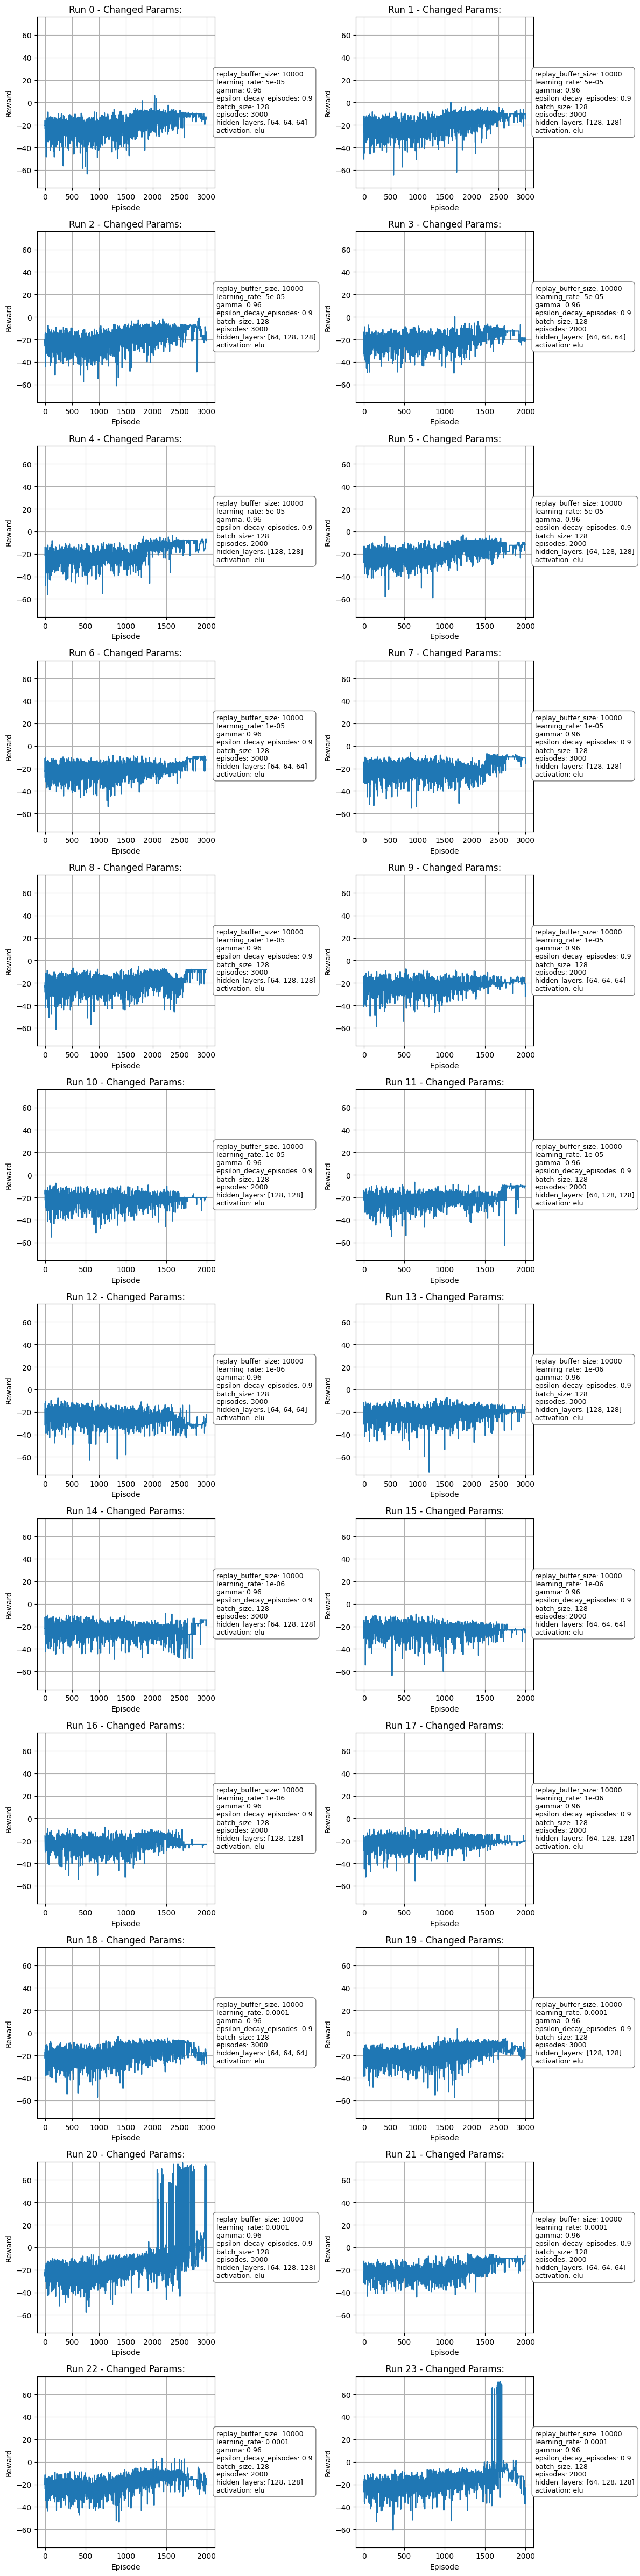

In [17]:
import math
import matplotlib.pyplot as plt

cols = 2
rows = math.ceil(len(results) / cols)

fig, axs = plt.subplots(rows, cols, figsize=(12, rows * 4))

if len(results) == 1:
    axs = [axs]

# Step 1: Find the max absolute reward for symmetric y-axis
max_reward = max(
    max(abs(min(result["rewards"])), abs(max(result["rewards"])))
    for result in results
)

# Round up to make the graph cleaner
y_limit = math.ceil(max_reward)

for i, result in enumerate(results):
    ax = axs[i // cols][i % cols] if rows > 1 else axs[i % cols]

    rewards = result["rewards"]
    changed = get_changed_hyperparams(shared_params, result["params"])

    ax.plot(rewards)
    ax.set_title(f"Run {i} - Changed Params:")
    ax.set_xlabel("Episode")
    ax.set_ylabel("Reward")
    ax.grid(True)

    # Step 2: Set a constant center of 0
    ax.set_ylim(-y_limit, y_limit)

    # Annotate changed hyperparameters
    annotation = "\n".join([f"{k}: {v}" for k, v in changed.items()])
    ax.text(1.01, 0.5, annotation, transform=ax.transAxes,
            fontsize=9, verticalalignment='center',
            bbox=dict(facecolor='white', edgecolor='gray', boxstyle='round,pad=0.5'))

# Hide any unused subplots
for j in range(i + 1, rows * cols):
    fig.delaxes(axs[j // cols][j % cols] if rows > 1 else axs[j % cols])

fig.tight_layout()
plt.savefig("comparison_plot2.png")
plt.show()


In [15]:
import pandas as pd
csv_data = []
for i, result in enumerate(results):
    param_row = {**result["params"]}
    param_row["run_id"] = i
    param_row["mean_reward"] = sum(result["rewards"]) / len(result["rewards"])
    param_row["max_reward"] = max(result["rewards"])
    param_row["min_reward"] = min(result["rewards"])
    csv_data.append(param_row)

df = pd.DataFrame(csv_data)
df.to_csv("results_log2.csv", index=False)
print("Saved results to results_log.csv")

Saved results to results_log.csv


In [16]:
# plt.figure(figsize=(10, 5))
# plt.hist(reward_log, bins=10, edgecolor='black')
# plt.title("Reward Distribution")
# plt.xlabel("Reward")
# plt.ylabel("Frequency")
# plt.grid(True)
# plt.show()
